#**Dataset**

O dataset utilizado consiste em imagens de jogadores de futebol coletadas de várias fontes. Cada jogador é representado por um conjunto de imagens disponíveis em subpastas nomeadas de acordo com o jogador específico. A fonte original do dataset é o Kaggle, mais especificamente o conjunto de dados "Golden Foot Football Players Image Dataset".

**Estrutura do Dataset**

O dataset está estruturado da seguinte forma:

Pasta Principal (*football_golden_foot/football_golden_foot*): Contém subpastas para cada jogador de futebol.
Cada subpasta possui várias imagens (.jpg e .png) do respectivo jogador.

**Número de classes e distribuição**

- **Número de classes**: O número de classes é igual ao número de jogadores representados no dataset. Cada classe é identificada pelo nome do jogador, como "Ronaldinho", "Ronaldo", "Messi", entre outros.

- **Distribuição**: A distribuição de imagens por classe pode variar, dependendo da quantidade de imagens disponíveis para cada jogador específico. Uma distribuição desigual pode impactar o treinamento do modelo, especialmente se algumas classes tiverem muito mais exemplos do que outras, porém mostramos ao decorrer da execução que essa distribuição é bastante balanceada.

**Características das Imagens**
- **Formato das imagens**: As imagens estão no formato RGB.

- **Resolução**: As imagens foram redimensionadas para um tamanho padrão de 128x128 pixels durante o pré-processamento para garantir que todas as imagens tenham o mesmo tamanho de entrada para o modelo.

#**Arquitetura da rede**

**Camadas Convolucionais e de Pooling**

- **Camadas iniciais**: A rede começa com camadas convolucionais que aplicam filtros para detectar características simples, como bordas e texturas, inicialmente com 32 filtros. A ativação é ReLU, escolhida por sua eficiência e capacidade de lidar com o problema de vanishing gradient.

- **Normalização em batch**: Após cada camada convolucional, é aplicada normalização em batch para estabilizar e acelerar o treinamento da rede.

- **Camadas de pooling**: Entre as camadas convolucionais, são inseridas camadas de max pooling para reduzir a dimensionalidade das features extraídas, mantendo as informações mais relevantes.

**Regularização e Redução de Overfitting**

- **Dropout**: Camadas de dropout são utilizadas após as camadas de pooling para regularizar o modelo e reduzir overfitting, onde 30% a 50% dos neurônios são aleatoriamente desativados durante o treinamento.

**Camadas densas**

- **Camadas densas:** Após a extração de características pelas camadas convolucionais e de pooling, as camadas densas são usadas para aprender padrões mais complexos nos dados transformados.
- **Função de ativação:** A função de ativação ReLU é novamente escolhida para as camadas densas, proporcionando não-linearidade e melhorando a capacidade do modelo de aprender representações mais abstratas dos dados.

**Camada de Saída**

- **Camada de saída:** A camada final é uma camada densa com função de ativação softmax, que produz uma distribuição de probabilidade sobre as classes de jogadores. Isso permite que o modelo determine qual jogador é mais provável estar representado na imagem.

#**Importação das Bibliotecas**

Importamos todas as bibliotecas necessárias para carregar, processar, treinar e avaliar nosso modelo de classificação de imagens.

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.activations import tanh, sigmoid, elu, gelu
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop

#**Download e Preparação do Dataset**

Baixamos e descompactamos o dataset de imagens de jogadores de futebol.

In [ ]:
!kaggle datasets download -d balabaskar/golden-foot-football-players-image-dataset --force

!unzip -q /content/golden-foot-football-players-image-dataset.zip

!ls /content/football_golden_foot/football_golden_foot

Dataset URL: https://www.kaggle.com/datasets/balabaskar/golden-foot-football-players-image-dataset
License(s): CC0-1.0
100% 516M/517M [00:28<00:00, 18.4MB/s]
100% 517M/517M [00:28<00:00, 19.3MB/s]
alessandro_del_piero  diego_maradona   lionel_messi   riyan_giggs      samuel_eto
andreas_iniesta       edinson_cavani   luka_modric    roberto_baggio   zlatan_ibrahimovic
andriy_shevchenko     francesco_totti  mohamed_salah  roberto_carlos
cristiano_ronaldo     gianlugi_buffon  pavel_nedved   ronaldinho
didier_drogba	      iker_casillas    pele	      ronaldo_nazario


**Divisão do Dataset**

Usamos a biblioteca split-folders para dividir o dataset em conjuntos de treinamento, validação e teste com uma proporção de 80%, 10%, e 10%, respectivamente.

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio('/content/football_golden_foot/football_golden_foot', output="/content/data", seed=1337, ratio=(.8, 0.1, 0.1))

Copying files: 7188 files [00:02, 3481.40 files/s]


**Carregamento e Pré-processamento das Imagens**

Definimos os caminhos dos conjuntos de treinamento e validação e listamos as pastas dentro desses conjuntos.


In [ ]:
path_train = '/content/data/train'
path_validation = '/content/data/val'

folder_train = os.listdir(path_train)
folder_validation = os.listdir(path_validation)

data_train = []
data_validation = []
img_size = 128

for folder in folder_train:
    path = os.path.join(path_train, folder)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            if img_array is None:
                print(f"Erro ao carregar imagem: {os.path.join(path, img)}")
            else:
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Converte de BGR para RGB
                new_img = cv2.resize(img_array, (img_size, img_size))
                data_train.append([new_img, folder])
        except Exception as e:
            print(f"Erro ao processar imagem: {os.path.join(path, img)} - {e}")

Carregamos e pré-processamos as imagens do conjunto de treinamento, convertendo de BGR para RGB e redimensionando para 128x128 pixels.


In [ ]:
for folder in folder_validation:
    path = os.path.join(path_validation, folder)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            if img_array is None:
                print(f"Erro ao carregar imagem: {os.path.join(path, img)}")
            else:
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Converte de BGR para RGB
                new_img = cv2.resize(img_array, (img_size, img_size))
                data_validation.append([new_img, folder])
        except Exception as e:
            print(f"Erro ao processar imagem: {os.path.join(path, img)} - {e}")

#**Separação de Features e Labels**

Separar as imagens (features) e suas respectivas classes (labels) para os conjuntos de treinamento e validação.

In [ ]:
X_train = []
y_train = []

for features, label in data_train:
  X_train.append(features)
  y_train.append(label)

X_validation = []
y_validation = []

for features, label in data_validation:
  X_validation.append(features)
  y_validation.append(label)


X_train = np.array(X_train)
y_train = np.array(y_train)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)


Plot das imagens por jogador

<Axes: xlabel='count'>

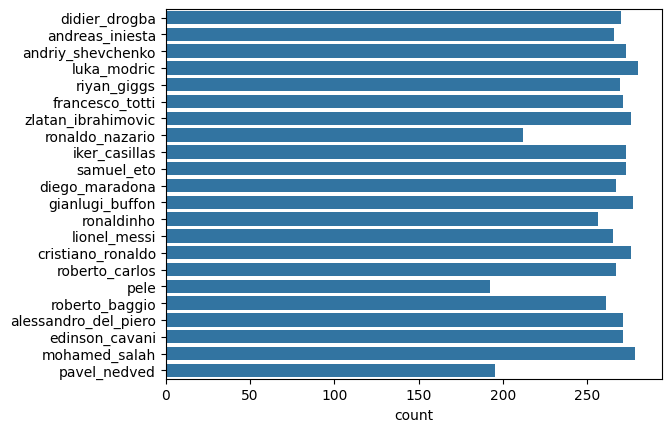

In [ ]:
sns.countplot(y_train)

**Normalização**

Redimensionar os arrays para incluir a dimensão dos canais e normalizar os valores dos pixels


In [ ]:
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
X_train=X_train / 255.0

X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 3)
X_validation=X_validation/255.0

print(X_train.shape)
print(X_validation.shape)

(5739, 128, 128, 3)
(708, 128, 128, 3)


**Codificação e One-hot Encoding**

Codificar as labels de texto em inteiros e, em seguida, aplicar one-hot encoding para usá-las na classificação.

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_validation = le.transform(y_validation)

y_train = to_categorical(y_train, num_classes=len(folder_train))
y_validation = to_categorical(y_validation, num_classes=len(folder_validation))

# Experimentos do Modelo Pré-Treinado

**Variação 1**: 1 camada densa, 512 neurônios, ativação relu, loss categorical_crossentropy, optimizer Adam

In [ ]:
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var1.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint]
)

Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 2.1651 - accuracy: 0.3912

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 110s 438ms/step - loss: 2.1651 - accuracy: 0.3912 - val_loss: 3.5638 - val_accuracy: 0.0494
Epoch 2/10
180/180 [==============================] - 24s 133ms/step - loss: 0.4332 - accuracy: 0.9003 - val_loss: 3.6489 - val_accuracy: 0.0381
Epoch 3/10
180/180 [==============================] - 24s 131ms/step - loss: 0.0641 - accuracy: 0.9949 - val_loss: 3.8143 - val_accuracy: 0.0636
Epoch 4/10
180/180 [==============================] - 41s 227ms/step - loss: 0.0196 - accuracy: 0.9988 - val_loss: 3.5121 - val_accuracy: 0.1455
Epoch 5/10
180/180 [==============================] - 35s 194ms/step - loss: 0.0122 - accuracy: 0.9981 - val_loss: 1.7643 - val_accuracy: 0.5226
Epoch 6/10
180/180 [==============================] - 37s 205ms/step - loss: 0.0083 - accuracy: 0.9984 - val_loss: 0.7251 - val_accuracy: 0.8192
Epoch 7/10
180/180 [==============================] - 43s 239ms/step - loss: 0.0062 - accuracy: 0.9990 - val_loss: 0.6938 - val_accuracy: 0.

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, y_validation)
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 37ms/step - loss: 0.7079 - accuracy: 0.8333
Test accuracy: 0.8333


**Variação 2**: 1 camada densa, 1024 neurônios, ativação relu, loss categorical_crossentropy, optimizer Adam

In [ ]:
# Variação 2: 1 camada densa, 1024 neurônios, ativação relu, loss categorical_crossentropy, optimizer Adam
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var2.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint]
)

Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 2.1544 - accuracy: 0.3894

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 69s 170ms/step - loss: 2.1544 - accuracy: 0.3894 - val_loss: 3.7586 - val_accuracy: 0.0466
Epoch 2/10
180/180 [==============================] - 57s 315ms/step - loss: 0.4270 - accuracy: 0.8981 - val_loss: 3.4322 - val_accuracy: 0.0636
Epoch 3/10
180/180 [==============================] - 23s 129ms/step - loss: 0.0649 - accuracy: 0.9929 - val_loss: 3.4332 - val_accuracy: 0.0537
Epoch 4/10
180/180 [==============================] - 33s 184ms/step - loss: 0.0177 - accuracy: 0.9977 - val_loss: 3.3819 - val_accuracy: 0.1667
Epoch 5/10
180/180 [==============================] - 33s 184ms/step - loss: 0.0094 - accuracy: 0.9983 - val_loss: 1.8595 - val_accuracy: 0.5254
Epoch 6/10
180/180 [==============================] - 37s 203ms/step - loss: 0.0068 - accuracy: 0.9988 - val_loss: 0.7743 - val_accuracy: 0.8291
Epoch 7/10
180/180 [==============================] - 35s 194ms/step - loss: 0.0063 - accuracy: 0.9984 - val_loss: 0.6752 - val_accuracy: 0.8

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, y_validation)
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 42ms/step - loss: 0.6923 - accuracy: 0.8362
Test accuracy: 0.8362


**Variação 3**: 1 camada densa, 2048 neurônios, ativação relu, loss categorical_crossentropy, optimizer Adam

In [ ]:
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var3.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint]
)

Epoch 1/10
180/180 [==============================] - 69s 212ms/step - loss: 2.0700 - accuracy: 0.4147 - val_loss: 3.9859 - val_accuracy: 0.0480
Epoch 2/10
180/180 [==============================] - 37s 205ms/step - loss: 0.4072 - accuracy: 0.9019 - val_loss: 3.2949 - val_accuracy: 0.0395
Epoch 3/10
180/180 [==============================] - 24s 131ms/step - loss: 0.0643 - accuracy: 0.9911 - val_loss: 3.5802 - val_accuracy: 0.0438
Epoch 4/10
180/180 [==============================] - 23s 130ms/step - loss: 0.0163 - accuracy: 0.9979 - val_loss: 3.9995 - val_accuracy: 0.1229
Epoch 5/10
180/180 [==============================] - 37s 207ms/step - loss: 0.0100 - accuracy: 0.9988 - val_loss: 1.9552 - val_accuracy: 0.5268
Epoch 6/10
180/180 [==============================] - 35s 193ms/step - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.7847 - val_accuracy: 0.8263
Epoch 7/10
180/180 [==============================] - 37s 203ms/step - loss: 0.0048 - accuracy: 0.9986 - val_loss: 0.7221 - val_ac

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, y_validation)
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 35ms/step - loss: 0.7975 - accuracy: 0.8319
Test accuracy: 0.8319


**Variação 4**: 1 camada densa, 512 neurônios, ativação tanh, loss categorical_crossentropy, optimizer Adam

In [ ]:
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='tanh')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var4.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint]
)

Epoch 1/10
180/180 [==============================] - 70s 209ms/step - loss: 2.0883 - accuracy: 0.4180 - val_loss: 3.2646 - val_accuracy: 0.0410
Epoch 2/10
180/180 [==============================] - 23s 128ms/step - loss: 0.3735 - accuracy: 0.9219 - val_loss: 3.4085 - val_accuracy: 0.0438
Epoch 3/10
180/180 [==============================] - 23s 129ms/step - loss: 0.0603 - accuracy: 0.9949 - val_loss: 3.3908 - val_accuracy: 0.0734
Epoch 4/10
180/180 [==============================] - 34s 191ms/step - loss: 0.0193 - accuracy: 0.9986 - val_loss: 2.9311 - val_accuracy: 0.2119
Epoch 5/10
180/180 [==============================] - 36s 203ms/step - loss: 0.0102 - accuracy: 0.9988 - val_loss: 1.4870 - val_accuracy: 0.5763
Epoch 6/10
180/180 [==============================] - 37s 203ms/step - loss: 0.0102 - accuracy: 0.9986 - val_loss: 0.7142 - val_accuracy: 0.8192
Epoch 7/10
180/180 [==============================] - 35s 194ms/step - loss: 0.0072 - accuracy: 0.9986 - val_loss: 0.6226 - val_ac

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, y_validation)
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 38ms/step - loss: 0.6369 - accuracy: 0.8390
Test accuracy: 0.8390


**Variação 5**: 2 camadas densas, 2048 neurônios, ativação relu, loss categorical_crossentropy, optimizer Adam

In [ ]:
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var12.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint]
)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 2.0787 - accuracy: 0.4015

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 68s 160ms/step - loss: 2.0787 - accuracy: 0.4015 - val_loss: 3.2873 - val_accuracy: 0.0438
Epoch 2/10
180/180 [==============================] - 24s 133ms/step - loss: 0.4854 - accuracy: 0.8608 - val_loss: 3.8822 - val_accuracy: 0.0339
Epoch 3/10
180/180 [==============================] - 24s 132ms/step - loss: 0.0994 - accuracy: 0.9786 - val_loss: 3.8959 - val_accuracy: 0.0537
Epoch 4/10
180/180 [==============================] - 24s 132ms/step - loss: 0.0579 - accuracy: 0.9868 - val_loss: 4.6151 - val_accuracy: 0.1695
Epoch 5/10
180/180 [==============================] - 23s 128ms/step - loss: 0.1050 - accuracy: 0.9693 - val_loss: 3.8568 - val_accuracy: 0.3489
Epoch 6/10
180/180 [==============================] - 26s 147ms/step - loss: 0.2357 - accuracy: 0.9270 - val_loss: 1.4505 - val_accuracy: 0.6907
Epoch 7/10
180/180 [==============================] - 30s 169ms/step - loss: 0.1162 - accuracy: 0.9665 - val_loss: 0.9077 - val_accuracy: 0.7

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, y_validation)
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 34ms/step - loss: 0.9795 - accuracy: 0.8008
Test accuracy: 0.8008


**Variação 6**: 3 camadas densas, 1024 neurônios, ativação tanh, loss categorical_crossentropy, optimizer Adam

In [ ]:
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='tanh')(x)
x = Dense(1024, activation='tanh')(x)
x = Dense(1024, activation='tanh')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var13.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint]
)

Epoch 1/10
180/180 [==============================] - 66s 161ms/step - loss: 2.0018 - accuracy: 0.4293 - val_loss: 4.0132 - val_accuracy: 0.0466
Epoch 2/10
180/180 [==============================] - 23s 128ms/step - loss: 0.3520 - accuracy: 0.9063 - val_loss: 4.4578 - val_accuracy: 0.0480
Epoch 3/10
180/180 [==============================] - 23s 130ms/step - loss: 0.0636 - accuracy: 0.9890 - val_loss: 4.2161 - val_accuracy: 0.0494
Epoch 4/10
180/180 [==============================] - 24s 134ms/step - loss: 0.0197 - accuracy: 0.9970 - val_loss: 4.1267 - val_accuracy: 0.1271
Epoch 5/10
180/180 [==============================] - 32s 181ms/step - loss: 0.0222 - accuracy: 0.9958 - val_loss: 1.9976 - val_accuracy: 0.4619
Epoch 6/10
180/180 [==============================] - 30s 169ms/step - loss: 0.0202 - accuracy: 0.9962 - val_loss: 0.8996 - val_accuracy: 0.7994
Epoch 7/10
180/180 [==============================] - 24s 130ms/step - loss: 0.0720 - accuracy: 0.9800 - val_loss: 1.4691 - val_ac

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, y_validation)
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 38ms/step - loss: 0.8236 - accuracy: 0.8432
Test accuracy: 0.8432


**Variação 7**: 2 camadas densas, 1024 neurônios, ativação tanh, loss categorical_crossentropy, optimizer Adam

In [ ]:
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='tanh')(x)
x = Dense(1024, activation='tanh')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var14.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint]
)

Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 2.0112 - accuracy: 0.4311

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 71s 179ms/step - loss: 2.0112 - accuracy: 0.4311 - val_loss: 4.2078 - val_accuracy: 0.0452
Epoch 2/10
180/180 [==============================] - 29s 163ms/step - loss: 0.3348 - accuracy: 0.9240 - val_loss: 3.4415 - val_accuracy: 0.0410
Epoch 3/10
180/180 [==============================] - 23s 128ms/step - loss: 0.0466 - accuracy: 0.9962 - val_loss: 3.4680 - val_accuracy: 0.0706
Epoch 4/10
180/180 [==============================] - 25s 136ms/step - loss: 0.0197 - accuracy: 0.9983 - val_loss: 3.1415 - val_accuracy: 0.2006
Epoch 5/10
180/180 [==============================] - 25s 141ms/step - loss: 0.0130 - accuracy: 0.9972 - val_loss: 1.7969 - val_accuracy: 0.5339
Epoch 6/10
180/180 [==============================] - 29s 163ms/step - loss: 0.0115 - accuracy: 0.9983 - val_loss: 0.7713 - val_accuracy: 0.8234
Epoch 7/10
180/180 [==============================] - 23s 127ms/step - loss: 0.0137 - accuracy: 0.9970 - val_loss: 0.7792 - val_accuracy: 0.8

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, y_validation)
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 38ms/step - loss: 0.7984 - accuracy: 0.8192
Test accuracy: 0.8192


**Variação 8**: 2 camadas densas, 1024 neurônios, ativação sigmoid, loss categorical_crossentropy, optimizer Adam

In [ ]:
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='sigmoid')(x)
x = Dense(1024, activation='sigmoid')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var17.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint]
)

Epoch 1/10
180/180 [==============================] - 63s 177ms/step - loss: 2.5686 - accuracy: 0.2750 - val_loss: 3.1742 - val_accuracy: 0.0480
Epoch 2/10
180/180 [==============================] - 30s 164ms/step - loss: 1.1141 - accuracy: 0.7059 - val_loss: 3.1723 - val_accuracy: 0.0424
Epoch 3/10
180/180 [==============================] - 30s 166ms/step - loss: 0.3807 - accuracy: 0.9078 - val_loss: 3.1424 - val_accuracy: 0.0763
Epoch 4/10
180/180 [==============================] - 23s 127ms/step - loss: 0.1958 - accuracy: 0.9533 - val_loss: 3.3049 - val_accuracy: 0.2034
Epoch 5/10
180/180 [==============================] - 30s 169ms/step - loss: 0.1323 - accuracy: 0.9650 - val_loss: 1.8880 - val_accuracy: 0.4972
Epoch 6/10
180/180 [==============================] - 29s 160ms/step - loss: 0.0884 - accuracy: 0.9800 - val_loss: 0.7659 - val_accuracy: 0.8107
Epoch 7/10
180/180 [==============================] - 35s 192ms/step - loss: 0.1131 - accuracy: 0.9697 - val_loss: 0.7529 - val_ac

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, y_validation)
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 39ms/step - loss: 0.7002 - accuracy: 0.8390
Test accuracy: 0.8390


**Variação 9**: 1 camada densa, 512 neurônios, ativação relu, loss sparse_categorical_crossentropy, optimizer Adam

In [ ]:
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

y_train_integer = np.argmax(y_train, axis=1)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var19.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train_integer,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, np.argmax(y_validation, axis=1)),
    callbacks=[model_checkpoint]
)

Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 2.1850 - accuracy: 0.3844

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 68s 207ms/step - loss: 2.1850 - accuracy: 0.3844 - val_loss: 3.2572 - val_accuracy: 0.0494
Epoch 2/10
180/180 [==============================] - 23s 126ms/step - loss: 0.4317 - accuracy: 0.9050 - val_loss: 3.3176 - val_accuracy: 0.0537
Epoch 3/10
180/180 [==============================] - 23s 130ms/step - loss: 0.0695 - accuracy: 0.9923 - val_loss: 3.2935 - val_accuracy: 0.0593
Epoch 4/10
180/180 [==============================] - 23s 130ms/step - loss: 0.0184 - accuracy: 0.9979 - val_loss: 3.3128 - val_accuracy: 0.1568
Epoch 5/10
180/180 [==============================] - 29s 160ms/step - loss: 0.0100 - accuracy: 0.9991 - val_loss: 1.9277 - val_accuracy: 0.4873
Epoch 6/10
180/180 [==============================] - 29s 160ms/step - loss: 0.0070 - accuracy: 0.9986 - val_loss: 0.7344 - val_accuracy: 0.8206
Epoch 7/10
180/180 [==============================] - 30s 164ms/step - loss: 0.0064 - accuracy: 0.9986 - val_loss: 0.6660 - val_accuracy: 0.8

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, np.argmax(y_validation, axis=1))
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 37ms/step - loss: 0.6958 - accuracy: 0.8277
Test accuracy: 0.8277


**Variação 10**: 2 camadas densas, 1024 neurônios, ativação relu, loss sparse_categorical_crossentropy, optimizer Adam

In [ ]:
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

y_train_integer = np.argmax(y_train, axis=1)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var23.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train_integer,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, np.argmax(y_validation, axis=1)),
    callbacks=[model_checkpoint]
)

Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 2.2097 - accuracy: 0.3750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 69s 159ms/step - loss: 2.2097 - accuracy: 0.3750 - val_loss: 3.6214 - val_accuracy: 0.0452
Epoch 2/10
180/180 [==============================] - 25s 139ms/step - loss: 0.5463 - accuracy: 0.8585 - val_loss: 3.5542 - val_accuracy: 0.0508
Epoch 3/10
180/180 [==============================] - 24s 131ms/step - loss: 0.1001 - accuracy: 0.9787 - val_loss: 3.7154 - val_accuracy: 0.0593
Epoch 4/10
180/180 [==============================] - 29s 163ms/step - loss: 0.0318 - accuracy: 0.9939 - val_loss: 3.5223 - val_accuracy: 0.1681
Epoch 5/10
180/180 [==============================] - 29s 161ms/step - loss: 0.0151 - accuracy: 0.9974 - val_loss: 1.7702 - val_accuracy: 0.5508
Epoch 6/10
180/180 [==============================] - 30s 168ms/step - loss: 0.0231 - accuracy: 0.9937 - val_loss: 0.9413 - val_accuracy: 0.7910
Epoch 7/10
180/180 [==============================] - 23s 127ms/step - loss: 0.1641 - accuracy: 0.9512 - val_loss: 2.3652 - val_accuracy: 0.5

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, np.argmax(y_validation, axis=1))
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 43ms/step - loss: 0.7814 - accuracy: 0.8277
Test accuracy: 0.8277


**Variação 11**: 1 camada densa, 1024 neurônios, ativação sigmoid, loss sparse_categorical_crossentropy, optimizer RMSprop

In [ ]:
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='sigmoid')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

y_train_integer = np.argmax(y_train, axis=1)

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var26.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train_integer,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, np.argmax(y_validation, axis=1)),
    callbacks=[model_checkpoint]
)

Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 2.1422 - accuracy: 0.3936

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 115s 167ms/step - loss: 2.1422 - accuracy: 0.3936 - val_loss: 3.2817 - val_accuracy: 0.0466
Epoch 2/10
180/180 [==============================] - 23s 127ms/step - loss: 0.6260 - accuracy: 0.8432 - val_loss: 3.4626 - val_accuracy: 0.0650
Epoch 3/10
180/180 [==============================] - 22s 124ms/step - loss: 0.1387 - accuracy: 0.9707 - val_loss: 4.1749 - val_accuracy: 0.0565
Epoch 4/10
180/180 [==============================] - 23s 126ms/step - loss: 0.0695 - accuracy: 0.9843 - val_loss: 3.3446 - val_accuracy: 0.1977
Epoch 5/10
180/180 [==============================] - 29s 161ms/step - loss: 0.0529 - accuracy: 0.9868 - val_loss: 2.4246 - val_accuracy: 0.4802
Epoch 6/10
180/180 [==============================] - 28s 155ms/step - loss: 0.0523 - accuracy: 0.9875 - val_loss: 0.8794 - val_accuracy: 0.8008
Epoch 7/10
180/180 [==============================] - 22s 124ms/step - loss: 0.0459 - accuracy: 0.9890 - val_loss: 1.0410 - val_accuracy: 0.

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, np.argmax(y_validation, axis=1))
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 40ms/step - loss: 0.9323 - accuracy: 0.7980
Test accuracy: 0.7980


**Variação 12**: 2 camadas densas, 1024 neurônios, ativação sigmoid, loss sparse_categorical_crossentropy, optimizer RMSprop

In [ ]:
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='sigmoid')(x)
x = Dense(1024, activation='sigmoid')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

y_train_integer = np.argmax(y_train, axis=1)

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var29.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train_integer,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, np.argmax(y_validation, axis=1)),
    callbacks=[model_checkpoint]
)


Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 2.6432 - accuracy: 0.2417

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 58s 171ms/step - loss: 2.6432 - accuracy: 0.2417 - val_loss: 3.1483 - val_accuracy: 0.0466
Epoch 2/10
180/180 [==============================] - 23s 126ms/step - loss: 1.2529 - accuracy: 0.6722 - val_loss: 3.2376 - val_accuracy: 0.0480
Epoch 3/10
180/180 [==============================] - 23s 126ms/step - loss: 0.4482 - accuracy: 0.8846 - val_loss: 3.3026 - val_accuracy: 0.0636
Epoch 4/10
180/180 [==============================] - 22s 124ms/step - loss: 0.1944 - accuracy: 0.9524 - val_loss: 3.5561 - val_accuracy: 0.1709
Epoch 5/10
180/180 [==============================] - 29s 161ms/step - loss: 0.1324 - accuracy: 0.9643 - val_loss: 2.1203 - val_accuracy: 0.4633
Epoch 6/10
180/180 [==============================] - 28s 157ms/step - loss: 0.1080 - accuracy: 0.9712 - val_loss: 0.8515 - val_accuracy: 0.7980
Epoch 7/10
180/180 [==============================] - 29s 159ms/step - loss: 0.0848 - accuracy: 0.9786 - val_loss: 0.7752 - val_accuracy: 0.8

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, np.argmax(y_validation, axis=1))
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 44ms/step - loss: 0.8343 - accuracy: 0.8150
Test accuracy: 0.8150


**Variação 13**: 3 camadas densas, 1024 neurônios, ativação relu, loss categorical_crossentropy, optimizer Adam

In [ ]:
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var31.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint]
)

Epoch 1/10
180/180 [==============================] - 69s 204ms/step - loss: 2.2693 - accuracy: 0.3422 - val_loss: 3.3563 - val_accuracy: 0.0395
Epoch 2/10
180/180 [==============================] - 23s 130ms/step - loss: 0.6804 - accuracy: 0.8089 - val_loss: 3.4736 - val_accuracy: 0.0452
Epoch 3/10
180/180 [==============================] - 23s 128ms/step - loss: 0.1391 - accuracy: 0.9650 - val_loss: 3.8674 - val_accuracy: 0.0579
Epoch 4/10
180/180 [==============================] - 34s 187ms/step - loss: 0.0690 - accuracy: 0.9807 - val_loss: 3.2410 - val_accuracy: 0.1638
Epoch 5/10
180/180 [==============================] - 29s 159ms/step - loss: 0.1108 - accuracy: 0.9671 - val_loss: 2.8632 - val_accuracy: 0.3969
Epoch 6/10
180/180 [==============================] - 29s 161ms/step - loss: 0.0966 - accuracy: 0.9721 - val_loss: 1.4845 - val_accuracy: 0.6893
Epoch 7/10
180/180 [==============================] - 35s 194ms/step - loss: 0.1945 - accuracy: 0.9415 - val_loss: 1.1738 - val_ac

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, y_validation)
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 40ms/step - loss: 0.7634 - accuracy: 0.8460
Test accuracy: 0.8460


**Variação 14**: 1 camada densa, 1024 neurônios, ativação relu, loss mean_squared_error, optimizer Adam

In [ ]:
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var32.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint]
)

Epoch 1/10
180/180 [==============================] - 75s 233ms/step - loss: 0.0365 - accuracy: 0.3122 - val_loss: 0.0438 - val_accuracy: 0.0381
Epoch 2/10
180/180 [==============================] - 38s 211ms/step - loss: 0.0172 - accuracy: 0.7184 - val_loss: 0.0437 - val_accuracy: 0.0593
Epoch 3/10
180/180 [==============================] - 24s 130ms/step - loss: 0.0080 - accuracy: 0.8740 - val_loss: 0.0452 - val_accuracy: 0.0523
Epoch 4/10
180/180 [==============================] - 23s 128ms/step - loss: 0.0043 - accuracy: 0.9364 - val_loss: 0.0454 - val_accuracy: 0.1822
Epoch 5/10
180/180 [==============================] - 39s 215ms/step - loss: 0.0026 - accuracy: 0.9631 - val_loss: 0.0321 - val_accuracy: 0.4675
Epoch 6/10
180/180 [==============================] - 36s 201ms/step - loss: 0.0025 - accuracy: 0.9629 - val_loss: 0.0179 - val_accuracy: 0.7232
Epoch 7/10
180/180 [==============================] - 35s 196ms/step - loss: 0.0032 - accuracy: 0.9552 - val_loss: 0.0166 - val_ac

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, y_validation)
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 38ms/step - loss: 0.0149 - accuracy: 0.7726
Test accuracy: 0.7726


**Variação 15**: 1 camada densa, 1024 neurônios, ativação relu, loss categorical_crossentropy, optimizer SGD

In [ ]:
num_classes = len(folder_train)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=SGD(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('resnet50_best_model_var33.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint]
)

Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 3.4538 - accuracy: 0.0483

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 48s 168ms/step - loss: 3.4538 - accuracy: 0.0483 - val_loss: 3.5344 - val_accuracy: 0.0452
Epoch 2/10
180/180 [==============================] - 28s 158ms/step - loss: 3.3140 - accuracy: 0.0538 - val_loss: 3.4858 - val_accuracy: 0.0438
Epoch 3/10
180/180 [==============================] - 29s 160ms/step - loss: 3.2327 - accuracy: 0.0631 - val_loss: 3.3085 - val_accuracy: 0.0311
Epoch 4/10
180/180 [==============================] - 28s 158ms/step - loss: 3.1671 - accuracy: 0.0706 - val_loss: 3.2625 - val_accuracy: 0.0523
Epoch 5/10
180/180 [==============================] - 23s 127ms/step - loss: 3.1131 - accuracy: 0.0782 - val_loss: 3.2676 - val_accuracy: 0.0551
Epoch 6/10
180/180 [==============================] - 28s 157ms/step - loss: 3.0574 - accuracy: 0.0906 - val_loss: 3.2054 - val_accuracy: 0.0678
Epoch 7/10
180/180 [==============================] - 25s 141ms/step - loss: 3.0174 - accuracy: 0.0978 - val_loss: 3.1370 - val_accuracy: 0.0

In [ ]:
test_loss, test_accuracy = model.evaluate(X_validation, y_validation)
print(f'Test accuracy: {test_accuracy:.4f}')

23/23 [==============================] - 1s 37ms/step - loss: 3.0568 - accuracy: 0.1045
Test accuracy: 0.1045


## Resultados do Modelo Pré-Treinado

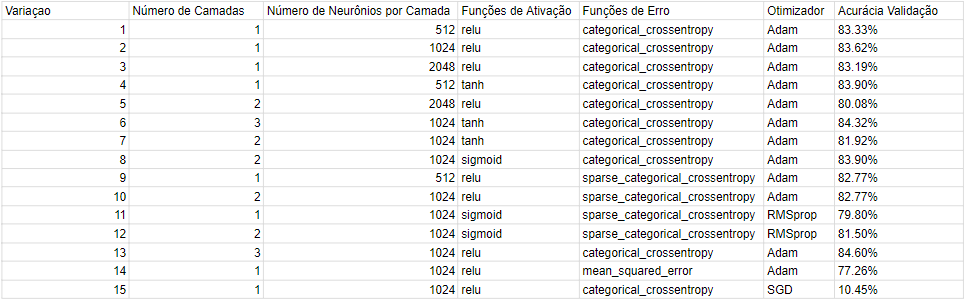

# Experimentos do Modelo Treinado do Zero

**Variaçao 1:**

**Número de Camadas:**

*   Conv2D (16 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (32 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Flatten
*   Dense (100 neurônios)
*   BatchNormalization

**Funções de Ativação:**

*   Conv2D: 'relu'
*   Dense: 'relu' e 'softmax'

**Função de Erro:** categorical_crossentropy

**Otimizador**: Adam

In [ ]:
# Teste 1
model = Sequential()

model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - ETA: 0s - loss: 1.2160 - accuracy: 0.7017
Epoch 2: val_loss did not improve from 3.52586
90/90 [==============================] - 3s 28ms/step - loss: 1.2160 - accuracy: 0.7017 - val_loss: 7.6394 - val_accuracy: 0.0325
Epoch 3/100
89/90 [============================>.] - ETA: 0s - loss: 0.2592 - accuracy: 0.9680
Epoch 3: val_loss did not improve from 3.52586
90/90 [==============================] - 2s 24ms/step - loss: 0.2589 - accuracy: 0.9681 - val_loss: 14.1265 - val_accuracy: 0.0339
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9976
Epoch 4: val_loss did not improve from 3.52586
90/90 [==============================] - 2s 25ms/step - loss: 0.0507 - accuracy: 0.9976 - val_loss: 12.4891 - val_accuracy: 0.0565
Epoch 5/100
88/90 [============================>.] - ETA: 0s - loss: 0.0194 - accuracy: 0.9988
Epoch 5: val_loss did not improve from 3.52586
90/90 [==============================] - 2s 25ms/ste

In [ ]:
# Resultados do Teste 1
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7372881174087524


**Variação 2:**

**Número de Camadas:**

*   Conv2D (16 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (16 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (32 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (32 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Flatten
*   Dense (100 neurônios)
*   BatchNormalization

**Funções de Ativação:**

*   Conv2D: 'relu'
*   Dense: 'relu' e 'softmax'

**Função de Erro:** categorical_crossentropy

**Otimizador**: Adam

In [ ]:
# Teste 2
model = Sequential()

model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_3 (Bat  (None, 128, 128, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 batch_normalization_4 (Bat  (None, 64, 64, 16)        64        
 chNormalization)                                                
                                                      

In [ ]:
# Resultados do Teste 2
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7132768630981445


**Variação 3:**

**Número de Camadas:**

*   Conv2D (16 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (16 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (32 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (32 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   Flatten
*   Dense (256 neurônios)
*   BatchNormalization

**Funções de Ativação:**

*   Conv2D: 'relu'
*   Dense: 'relu' e 'softmax'

**Função de Erro:** categorical_crossentropy

**Otimizador:** Adam

In [ ]:
# Teste 3
model = Sequential()

model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], verbose=2, shuffle=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_16 (Ba  (None, 128, 128, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 16)        2320      
                                                                 
 batch_normalization_17 (Ba  (None, 64, 64, 16)        64        
 tchNormalization)                                               
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 - 12s - loss: 3.0989 - accuracy: 0.1234 - val_loss: 3.1071 - val_accuracy: 0.0494 - 12s/epoch - 137ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 3.10712
90/90 - 3s - loss: 2.5538 - accuracy: 0.2304 - val_loss: 3.1675 - val_accuracy: 0.0466 - 3s/epoch - 28ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 3.10712
90/90 - 2s - loss: 2.2422 - accuracy: 0.3272 - val_loss: 3.6111 - val_accuracy: 0.0452 - 2s/epoch - 25ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 3.10712
90/90 - 2s - loss: 1.9140 - accuracy: 0.4224 - val_loss: 3.2316 - val_accuracy: 0.0975 - 2s/epoch - 25ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 3.10712
90/90 - 2s - loss: 1.5871 - accuracy: 0.5245 - val_loss: 3.7246 - val_accuracy: 0.1186 - 2s/epoch - 25ms/step
Epoch 6/100

Epoch 6: val_loss improved from 3.10712 to 2.81445, saving model to model.weights.best.hdf5
90/90 - 2s - loss: 1.2917 - accuracy: 0.6048 - val_loss: 2.8145 - val_accuracy: 0.2599 - 2s/epoch - 27

In [ ]:
# Resultados do Teste 3
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7542372941970825


**Variação 4:**

**Número de Camadas:**

*   Conv2D (32 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (32 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (256 filtros)
*   BatchNormalization
*   Flatten
*   Dense (500 neurônios)
*   BatchNormalization

**Funções de Ativação**:

*   Conv2D: 'relu'
*   Dense: 'relu' e 'softmax'

**Função de Erro:** categorical_crossentropy

**Otimizador:** Adam

In [ ]:
# Teste 4
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], verbose=2, shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 3.14661
90/90 - 4s - loss: 2.5228 - accuracy: 0.2507 - val_loss: 3.4465 - val_accuracy: 0.0466 - 4s/epoch - 41ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 3.14661
90/90 - 3s - loss: 2.2021 - accuracy: 0.3534 - val_loss: 3.5199 - val_accuracy: 0.0621 - 3s/epoch - 38ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 3.14661
90/90 - 3s - loss: 1.8516 - accuracy: 0.4541 - val_loss: 3.6399 - val_accuracy: 0.0763 - 3s/epoch - 38ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 3.14661
90/90 - 3s - loss: 1.3943 - accuracy: 0.5863 - val_loss: 3.3430 - val_accuracy: 0.1709 - 3s/epoch - 38ms/step
Epoch 6/100

Epoch 6: val_loss improved from 3.14661 to 2.41529, saving model to model.weights.best.hdf5
90/90 - 4s - loss: 1.0587 - accuracy: 0.6825 - val_loss: 2.4153 - val_accuracy: 0.3602 - 4s/epoch - 39ms/step
Epoch 7/100

Epoch 7: val_loss improved from 2.41529 to 1.76575, saving model to model.weights.best.hdf5
90/90 - 3s -

In [ ]:
# Resultados do Teste 4
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7725988626480103


**Variação 5:**

**Número de Camadas:**

*   Conv2D (4 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (4 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (8 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (8 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (16 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (16 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (32 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (32 filtros)
*   BatchNormalization
*   Flatten
*   Dense (50 neurônios)
*   BatchNormalization

**Funções de Ativação:**

*   Conv2D: 'relu'
*   Dense: 'relu' e 'softmax'

**Função de Erro:** categorical_crossentropy

**Otimizador:** Adam

In [ ]:
# Teste 5
model = Sequential()

model.add(Conv2D(4, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(4, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(8, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(8, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], verbose=2, shuffle=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 4)       112       
                                                                 
 batch_normalization_9 (Bat  (None, 128, 128, 4)       16        
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 4)         148       
                                                                 
 batch_normalization_10 (Ba  (None, 64, 64, 4)         16        
 tchNormalization)                                               
                                                      

In [ ]:
# Resultados do Teste 5
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.16525423526763916


**Variação 6:**

**Número de Camadas:**

*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (512 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (512 filtros)
*   BatchNormalization
*   Flatten
*   Dense (1000 neurônios)
*   BatchNormalization

**Funções de Ativação:**

*   Conv2D: 'relu'
*   Dense: 'relu' e 'softmax'

**Função de Erro:** categorical_crossentropy

**Otimizador:** Adam

In [ ]:
# Teste 6
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], verbose=2, shuffle=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_9 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_10 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                      

In [ ]:
# Resultados do Teste 6
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7867231369018555


**Variação 7:**

**Número de Camadas:**

*   Conv2D (32 filtros)
*   BatchNormalization
*   Conv2D (32 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Dropout (0.3)
*   Conv2D (64 filtros)
*   BatchNormalization
*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Dropout (0.5)
*   Conv2D (128 filtros)
*   BatchNormalization
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Dropout (0.5)
*   Flatten
*   Dense (128 neurônios)
*   BatchNormalization
*   Dropout (0.5)

**Funções de Ativação:**

*   Conv2D: 'relu'
*   Dense: 'relu' e 'softmax'

**Função de Erro:** categorical_crossentropy

**Otimizador:** Adam

In [ ]:
# Teste 7
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(folder_train), activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer],
          verbose=2, shuffle=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_7 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_8 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 - 22s - loss: 3.2960 - accuracy: 0.1032 - val_loss: 3.2524 - val_accuracy: 0.0466 - 22s/epoch - 246ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 3.25237
90/90 - 13s - loss: 2.8247 - accuracy: 0.1823 - val_loss: 6.2855 - val_accuracy: 0.0466 - 13s/epoch - 143ms/step
Epoch 3/100

Epoch 3: val_loss improved from 3.25237 to 3.17558, saving model to model.weights.best.hdf5
90/90 - 13s - loss: 2.5118 - accuracy: 0.2624 - val_loss: 3.1756 - val_accuracy: 0.0749 - 13s/epoch - 146ms/step
Epoch 4/100

Epoch 4: val_loss improved from 3.17558 to 2.91804, saving model to model.weights.best.hdf5
90/90 - 13s - loss: 2.1356 - accuracy: 0.3711 - val_loss: 2.9180 - val_accuracy: 0.1314 - 13s/epoch - 147ms/step
Epoch 5/100

Epoch 5: val_loss improved from 2.91804 to 2.63210, saving model to model.weights.best.hdf5
90/90 - 13s - loss: 1.8774 - accuracy: 0.4431 - val_loss: 2.6321 - val_accuracy: 0.2684 - 13s/epoch - 147ms/step
Epoch 6/100

Epoch 6: val_loss improved from 2.63210 to 2.23

In [ ]:
# Resultados do Teste 7
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7485875487327576


**Variação 8:**

**Número de Camadas:**

*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (512 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (512 filtros)
*   BatchNormalization
*   Flatten
*   Dense (1000 neurônios)
*   BatchNormalization

**Funções de Ativação:**

*   Conv2D: 'relu'
*   Dense: 'relu' e 'softmax'

**Função de Erro:** categorical_crossentropy

**Otimizador:** SGD

In [ ]:
# Teste 8
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='softmax'))

model.summary()

model.compile(optimizer='SGD', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], verbose=2, shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 3.12144
90/90 - 6s - loss: 2.1092 - accuracy: 0.3898 - val_loss: 3.3026 - val_accuracy: 0.0353 - 6s/epoch - 66ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 3.12144
90/90 - 6s - loss: 1.3470 - accuracy: 0.6229 - val_loss: 3.5842 - val_accuracy: 0.0692 - 6s/epoch - 67ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 3.12144
90/90 - 6s - loss: 0.6972 - accuracy: 0.8231 - val_loss: 3.2156 - val_accuracy: 0.1257 - 6s/epoch - 67ms/step
Epoch 5/100

Epoch 5: val_loss improved from 3.12144 to 2.38416, saving model to model.weights.best.hdf5
90/90 - 6s - loss: 0.2699 - accuracy: 0.9503 - val_loss: 2.3842 - val_accuracy: 0.3079 - 6s/epoch - 69ms/step
Epoch 6/100

Epoch 6: val_loss improved from 2.38416 to 1.40160, saving model to model.weights.best.hdf5
90/90 - 6s - loss: 0.0809 - accuracy: 0.9946 - val_loss: 1.4016 - val_accuracy: 0.6540 - 6s/epoch - 69ms/step
Epoch 7/100

Epoch 7: val_loss improved from 1.40160 to 1.11129, saving 

In [ ]:
# Resultados do Teste 8
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7570621371269226


**Variação 9:**

**Número de Camadas:**

*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (512 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (512 filtros)
*   BatchNormalization
*   Flatten
*   Dense (1000 neurônios)
*   BatchNormalization'

**Funções de Ativação:**

*   Conv2D: 'relu'
*   Dense: 'relu' e 'softmax'

**Função de Erro:** categorical_crossentropy

**Otimizador:** Adadelta

In [ ]:
# Teste 9
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='softmax'))

model.summary()

model.compile(optimizer='Adadelta', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], verbose=2, shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 - 22s - loss: 3.8911 - accuracy: 0.0463 - val_loss: 3.1331 - val_accuracy: 0.0466 - 22s/epoch - 239ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 3.13308
90/90 - 6s - loss: 3.7686 - accuracy: 0.0563 - val_loss: 3.1785 - val_accuracy: 0.0523 - 6s/epoch - 69ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 3.13308
90/90 - 6s - loss: 3.6251 - accuracy: 0.0688 - val_loss: 3.2219 - val_accuracy: 0.0508 - 6s/epoch - 69ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 3.13308
90/90 - 6s - loss: 3.5205 - accuracy: 0.0741 - val_loss: 3.3569 - val_accuracy: 0.0537 - 6s/epoch - 70ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 3.13308
90/90 - 6s - loss: 3.4195 - accuracy: 0.0878 - val_loss: 3.5143 - val_accuracy: 0.0438 - 6s/epoch - 70ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 3.13308
90/90 - 6s - loss: 3.3443 - accuracy: 0.0960 - val_loss: 3.4734 - val_accuracy: 0.0706 - 6s/epoch - 70ms/step
Epoch 7/100

Epoch 7: val_loss did no

In [ ]:
# Resultados do Teste 9
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.3446327745914459


**Variação 10:**

**Número de Camadas:**

*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (512 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (512 filtros)
*   BatchNormalization
*   Flatten
*   Dense (1000 neurônios)
*   BatchNormalization

**Funções de Ativação:**

*   Conv2D: 'relu'
*   Dense: 'relu' e 'softmax'

**Função de Erro:** categorical_crossentropy

**Otimizador:** RMSprop

In [ ]:
# Teste 10
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='softmax'))

model.summary()

model.compile(optimizer='RMSprop', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], verbose=2, shuffle=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_9 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_10 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                      

In [ ]:
# Resultados do Teste 10
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7641242742538452


**Variação 11:**

**Número de Camadas:**

*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Flatten
*   Dense (1000 neurônios)
*   BatchNormalization

**Funções de Ativação:**

*   Conv2D: 'relu' e 'tanh'
*   Dense: 'sigmoid'

**Função de Erro:** categorical_crossentropy

**Otimizador:** RMSprop

In [ ]:
# Teste 11
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(1000, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='sigmoid'))

model.summary()

model.compile(optimizer='RMSprop', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], verbose=2, shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 5.71262
90/90 - 5s - loss: 2.3192 - accuracy: 0.3290 - val_loss: 7.2429 - val_accuracy: 0.0678 - 5s/epoch - 61ms/step
Epoch 3/100

Epoch 3: val_loss improved from 5.71262 to 3.84507, saving model to model.weights.best.hdf5
90/90 - 6s - loss: 1.5057 - accuracy: 0.5682 - val_loss: 3.8451 - val_accuracy: 0.1229 - 6s/epoch - 64ms/step
Epoch 4/100

Epoch 4: val_loss improved from 3.84507 to 3.14075, saving model to model.weights.best.hdf5
90/90 - 6s - loss: 0.8482 - accuracy: 0.7625 - val_loss: 3.1407 - val_accuracy: 0.2528 - 6s/epoch - 63ms/step
Epoch 5/100

Epoch 5: val_loss improved from 3.14075 to 2.56435, saving model to model.weights.best.hdf5
90/90 - 6s - loss: 0.4486 - accuracy: 0.8834 - val_loss: 2.5644 - val_accuracy: 0.3927 - 6s/epoch - 66ms/step
Epoch 6/100

Epoch 6: val_loss improved from 2.56435 to 1.69166, saving model to model.weights.best.hdf5
90/90 - 6s - loss: 0.2352 - accuracy: 0.9401 - val_loss: 1.6917 - val_accuracy: 0.6356 - 6s/

In [ ]:
# Resultados do Teste 11
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7302259802818298


**Variação 12:**

**Número de Camadas:**

*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Flatten
*   Dense (1000 neurônios)
*   BatchNormalization

**Funções de Ativação:**

*   Conv2D: 'tanh'
*   Dense: 'sigmoid'

**Função de Erro:** binary_crossentropy

**Otimizador:** Adam

In [ ]:
# Teste 12
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', activation='tanh', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='tanh', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3,3), padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(1000, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], verbose=2, shuffle=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_12 (Ba  (None, 128, 128, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_13 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.21531 to 0.18461, saving model to model.weights.best.hdf5
90/90 - 7s - loss: 0.1648 - accuracy: 0.2143 - val_loss: 0.1846 - val_accuracy: 0.1483 - 7s/epoch - 74ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.18461 to 0.18186, saving model to model.weights.best.hdf5
90/90 - 7s - loss: 0.1505 - accuracy: 0.3009 - val_loss: 0.1819 - val_accuracy: 0.1963 - 7s/epoch - 76ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.18186 to 0.16953, saving model to model.weights.best.hdf5
90/90 - 7s - loss: 0.1369 - accuracy: 0.3924 - val_loss: 0.1695 - val_accuracy: 0.2274 - 7s/epoch - 74ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.16953 to 0.15938, saving model to model.weights.best.hdf5
90/90 - 7s - loss: 0.1200 - accuracy: 0.4834 - val_loss: 0.1594 - val_accuracy: 0.2980 - 7s/epoch - 75ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.15938
90/90 - 6s - loss: 0.0999 - accuracy: 0.6048 - val_loss: 0.1612 - val_accuracy: 0.3319 - 6s/

In [ ]:
# Resultados do Teste 12
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7471751570701599


**Variação 13:**

**Número de Camadas:**

*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (512 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (512 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Flatten
*   Dense (1000 neurônios)
*   BatchNormalization

**Funções de Ativação:**

*   Conv2D: 'elu' e 'tanh'
*   Dense: 'sigmoid'

**Função de Erro:** binary_crossentropy

**Otimizador:** SGD

In [ ]:
# Teste 13
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', activation='elu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='elu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3,3), padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, (3,3), padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3,3), padding='same', activation='tanh'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1000, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='sigmoid'))

model.summary()

model.compile(optimizer='SGD', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], verbose=2, shuffle=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 - 24s - loss: 0.7658 - accuracy: 0.0802 - val_loss: 0.7584 - val_accuracy: 0.0466 - 24s/epoch - 263ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.75839 to 0.70732, saving model to model.weights.best.hdf5
90/90 - 8s - loss: 0.6841 - accuracy: 0.1769 - val_loss: 0.7073 - val_accuracy: 0.0466 - 8s/epoch - 84ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.70732 to 0.67683, saving model to model.weights.best.hdf5
90/90 - 7s - loss: 0.6463 - accuracy: 0.2612 - val_loss: 0.6768 - val_accuracy: 0.0254 - 7s/epoch - 81ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.67683 to 0.64018, saving model to model.weights.best.hdf5
90/90 - 7s - loss: 0.6170 - accuracy: 0.3375 - val_loss: 0.6402 - val_accuracy: 0.0494 - 7s/epoch - 81ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.64018 to 0.60509, saving model to model.weights.best.hdf5
90/90 - 7s - loss: 0.5906 - accuracy: 0.4072 - val_loss: 0.6051 - val_accuracy: 0.1088 - 7s/epoch - 83ms/step
Epoch 6/100

Epoch 6: val_l

In [ ]:
# Resultados do Teste 13
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7231638431549072


**Variação 14:**

**Número de Camadas:**

*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (512 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (512 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Flatten
*   Dense (1000 neurônios)
*   BatchNormalization

**Funções de Ativação:**

*   Conv2D: 'tanh' e 'gelu'
*   Dense: 'sigmoid' e 'softmax'

**Função de Erro:** binary_crossentropy

**Otimizador:** Adadelta

In [ ]:
# Teste 14
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', activation='tanh', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='tanh', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='gelu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3,3), padding='same', activation='gelu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, (3,3), padding='same', activation='gelu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3,3), padding='same', activation='gelu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1000, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='softmax'))

model.summary()

model.compile(optimizer='Adadelta', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], verbose=2, shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 - 24s - loss: 0.8688 - accuracy: 0.0554 - val_loss: 0.6737 - val_accuracy: 0.0466 - 24s/epoch - 262ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 0.67372
90/90 - 7s - loss: 0.8494 - accuracy: 0.0592 - val_loss: 0.6894 - val_accuracy: 0.0480 - 7s/epoch - 77ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 0.67372
90/90 - 7s - loss: 0.8359 - accuracy: 0.0619 - val_loss: 0.7168 - val_accuracy: 0.0523 - 7s/epoch - 82ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.67372
90/90 - 7s - loss: 0.8249 - accuracy: 0.0683 - val_loss: 0.7420 - val_accuracy: 0.0452 - 7s/epoch - 78ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.67372
90/90 - 7s - loss: 0.8156 - accuracy: 0.0725 - val_loss: 0.7576 - val_accuracy: 0.0579 - 7s/epoch - 82ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.67372
90/90 - 7s - loss: 0.8064 - accuracy: 0.0863 - val_loss: 0.7709 - val_accuracy: 0.0579 - 7s/epoch - 79ms/step
Epoch 7/100

Epoch 7: val_loss did no

In [ ]:
# Resultados do Teste 14
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.30367231369018555


**Variação 15:**

**Número de Camadas:**

*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (64 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (128 filtros)
*   BatchNormalization
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (256 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (512 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Conv2D (512 filtros)
*   BatchNormalization
*   MaxPooling2D
*   Flatten
*   Dense (1000 neurônios)
*   BatchNormalization

**Funções de Ativação:**

*   Conv2D: 'relu', 'tanh' e 'gelu'
*   Dense: 'sigmoid'

**Função de Erro:** binary_crossentropy

**Otimizador:** RMSprop

In [ ]:
# Teste 15
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='gelu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3,3), padding='same', activation='gelu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, (3,3), padding='same', activation='gelu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3,3), padding='same', activation='gelu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1000, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='sigmoid'))

model.summary()

model.compile(optimizer='RMSprop', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], verbose=2, shuffle=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_9 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_10 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                      

In [ ]:
# Resultados do Teste 15
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7725988626480103


## Resultados do Modelo Treinado do Zero

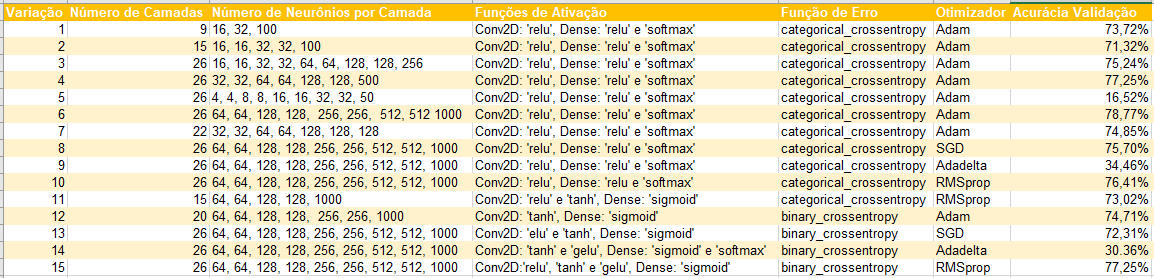

#**Definição da Arquitetura do Modelo Pré-Treinado**

In [ ]:
num_classes = len(folder_train)

# Carregar o modelo ResNet50 pré-treinado (sem a camada de saída)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Adicionar camadas de saída personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Criar o modelo final
model_one = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model_one.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
model_checkpoint = ModelCheckpoint('resnet50_best_model.h5', monitor='val_loss', save_best_only=True)

# Treinar o modelo com validação cruzada
history = model_one.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint]
)

Epoch 1/30
180/180 [==============================] - 67s 200ms/step - loss: 2.2482 - accuracy: 0.3516 - val_loss: 3.3208 - val_accuracy: 0.0367
Epoch 2/30
180/180 [==============================] - 23s 128ms/step - loss: 0.6745 - accuracy: 0.8054 - val_loss: 3.7163 - val_accuracy: 0.0494
Epoch 3/30
180/180 [==============================] - 22s 124ms/step - loss: 0.1477 - accuracy: 0.9592 - val_loss: 3.9381 - val_accuracy: 0.0847
Epoch 4/30
180/180 [==============================] - 22s 124ms/step - loss: 0.0402 - accuracy: 0.9925 - val_loss: 5.0186 - val_accuracy: 0.0960
Epoch 5/30
180/180 [==============================] - 34s 192ms/step - loss: 0.0401 - accuracy: 0.9899 - val_loss: 2.3405 - val_accuracy: 0.4647
Epoch 6/30
180/180 [==============================] - 23s 127ms/step - loss: 0.2103 - accuracy: 0.9380 - val_loss: 2.6603 - val_accuracy: 0.5155
Epoch 7/30
180/180 [==============================] - 33s 182ms/step - loss: 0.2047 - accuracy: 0.9350 - val_loss: 1.1242 - val_ac

## Visualização dos Resultados do Treinamento

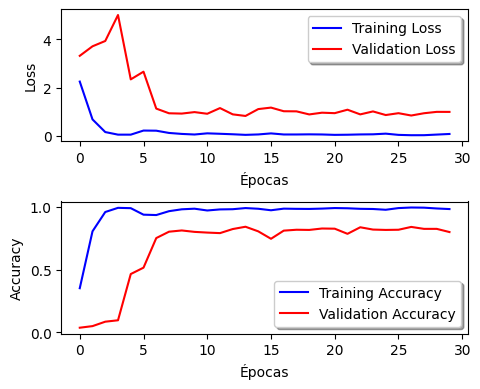

In [ ]:
# Plotar os gráficos de perda e acurácia
fig, ax = plt.subplots(2, 1, figsize=(5, 4))

# Plotando a perda (loss)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_xlabel('Épocas')
ax[0].set_ylabel('Loss')

# Plotando a precisão (accuracy)
ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation Accuracy")
ax[1].legend(loc='best', shadow=True)
ax[1].set_xlabel('Épocas')
ax[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

## Avaliação do Modelo

In [ ]:
model_one.load_weights('/content/resnet50_best_model.h5')

score = model_one.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.8418079018592834



**Relatório de Classificação**

Mapeamos as classes para os nomes dos jogadores, realizamos previsões no conjunto de validação e geramos um relatório de classificação com precisão, recall e f1-score para cada classe.

In [ ]:
# Lista de jogadores para mapeamento de classes
jogadores = ['alessandro_del_piero', 'andreas_iniesta', 'andriy_shevchenko', 'cristiano_ronaldo',
             'didier_drogba', 'diego_maradona', 'edinson_cavani', 'francesco_totti', 'gianlugi_buffon',
             'iker_casillas', 'lionel_messi', 'luka_modric', 'mohamed_salah', 'pavel_nedved', 'pele',
             'riyan_giggs', 'roberto_baggio', 'roberto_carlos', 'ronaldinho', 'ronaldo_nazario', 'samuel_eto',
             'zlatan_ibrahimovic']

# Prever os rótulos no conjunto de validação
y_pred = model_one.predict(X_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

report = classification_report(y_true, y_pred_classes, target_names=jogadores)
print(report)

23/23 [==============================] - 2s 37ms/step
                      precision    recall  f1-score   support

alessandro_del_piero       0.96      0.70      0.81        33
     andreas_iniesta       0.94      0.88      0.91        33
   andriy_shevchenko       0.87      0.76      0.81        34
   cristiano_ronaldo       0.81      0.85      0.83        34
       didier_drogba       0.90      0.82      0.86        33
      diego_maradona       0.86      0.94      0.90        33
      edinson_cavani       0.78      0.94      0.85        33
     francesco_totti       0.72      0.88      0.79        33
     gianlugi_buffon       0.77      1.00      0.87        34
       iker_casillas       0.91      0.91      0.91        34
        lionel_messi       0.86      0.73      0.79        33
         luka_modric       0.90      0.80      0.85        35
       mohamed_salah       0.87      1.00      0.93        34
        pavel_nedved       0.88      0.92      0.90        24
               

#**Definição da Arquitetura do Modelo Treinado do Zero**

Definir a arquitetura do modelo com camadas convolucionais, pooling, normalização e camadas densas com dropout.

In [ ]:
# Definir a arquitetura do modelo
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(folder_train), activation='softmax'))

**Compilação e Treinamento do Modelo**

Compilamos o modelo com otimizador Adam e função de perda categorical crossentropy. Usamos callbacks para salvar o melhor modelo durante o treinamento.


In [ ]:
model.summary()

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=100,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], verbose=2, shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 - 25s - loss: 3.1214 - accuracy: 0.1453 - val_loss: 3.2014 - val_accuracy: 0.0593 - 25s/epoch - 283ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 3.20143
90/90 - 6s - loss: 2.5581 - accuracy: 0.2480 - val_loss: 3.5127 - val_accuracy: 0.0494 - 6s/epoch - 68ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 3.20143
90/90 - 6s - loss: 2.2467 - accuracy: 0.3332 - val_loss: 4.2572 - val_accuracy: 0.0410 - 6s/epoch - 68ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 3.20143
90/90 - 6s - loss: 1.8717 - accuracy: 0.4459 - val_loss: 4.9325 - val_accuracy: 0.0523 - 6s/epoch - 67ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 3.20143
90/90 - 6s - loss: 1.4519 - accuracy: 0.5696 - val_loss: 5.1281 - val_accuracy: 0.1102 - 6s/epoch - 70ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 3.20143
90/90 - 6s - loss: 1.0967 - accuracy: 0.6790 - val_loss: 3.3389 - val_accuracy: 0.2740 - 6s/epoch - 69ms/step
Epoch 7/100

Epoch 7: val_loss improv

##**Visualização dos Resultados do Treinamento**

Plotamos gráficos de perda e acurácia para visualizarmos o desempenho do modelo durante o treinamento.

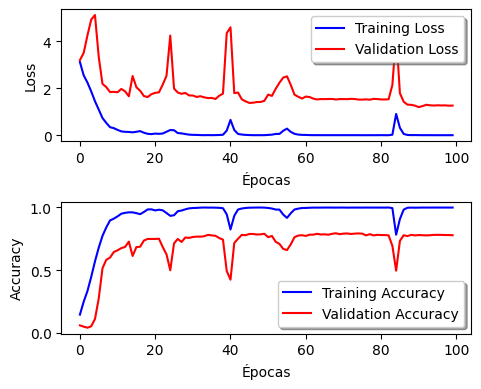

In [ ]:
# Plotar os gráficos de perda e acurácia
fig, ax = plt.subplots(2, 1, figsize=(5, 4))

# Plotando a perda (loss)
ax[0].plot(hist.history['loss'], color='b', label="Training Loss")
ax[0].plot(hist.history['val_loss'], color='r', label="Validation Loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_xlabel('Épocas')
ax[0].set_ylabel('Loss')

# Plotando a precisão (accuracy)
ax[1].plot(hist.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r', label="Validation Accuracy")
ax[1].legend(loc='best', shadow=True)
ax[1].set_xlabel('Épocas')
ax[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

##**Avaliação do Modelo**

Carregamos os melhores pesos salvos e avaliamos o modelo no conjunto de validação para obter a acurácia final.

In [ ]:
model.load_weights('/content/model.weights.best.hdf5')

score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7796609997749329


**Relatório de Classificação**

Mapeamos as classes para os nomes dos jogadores, realizamos previsões no conjunto de validação e geramos um relatório de classificação com precisão, recall e f1-score para cada classe.

In [ ]:
# Lista de jogadores para mapeamento de classes
jogadores = ['alessandro_del_piero', 'andreas_iniesta', 'andriy_shevchenko', 'cristiano_ronaldo',
             'didier_drogba', 'diego_maradona', 'edinson_cavani', 'francesco_totti', 'gianlugi_buffon',
             'iker_casillas', 'lionel_messi', 'luka_modric', 'mohamed_salah', 'pavel_nedved', 'pele',
             'riyan_giggs', 'roberto_baggio', 'roberto_carlos', 'ronaldinho', 'ronaldo_nazario', 'samuel_eto',
             'zlatan_ibrahimovic']

# Prever os rótulos no conjunto de validação
y_pred = model.predict(X_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

report = classification_report(y_true, y_pred_classes, target_names=jogadores)
print(report)

23/23 [==============================] - 1s 14ms/step
                      precision    recall  f1-score   support

alessandro_del_piero       0.64      0.76      0.69        33
     andreas_iniesta       0.79      0.79      0.79        33
   andriy_shevchenko       0.74      0.74      0.74        34
   cristiano_ronaldo       1.00      0.76      0.87        34
       didier_drogba       0.73      0.82      0.77        33
      diego_maradona       0.73      0.73      0.73        33
      edinson_cavani       0.81      0.79      0.80        33
     francesco_totti       0.72      0.79      0.75        33
     gianlugi_buffon       0.89      0.97      0.93        34
       iker_casillas       0.82      0.82      0.82        34
        lionel_messi       0.64      0.76      0.69        33
         luka_modric       0.93      0.74      0.83        35
       mohamed_salah       0.78      0.82      0.80        34
        pavel_nedved       0.90      0.79      0.84        24
               

#Testes Modelo Pré Treinado

##**Seleção de Imagens Aleatórias e Previsões**


- Importamos as bibliotecas os e random para manipulação de arquivos e seleção aleatória, respectivamente.
- Definimos o caminho para a pasta que contém as imagens de teste
- Especificamos a quantidade de imagens que queremos selecionar aleatoriamente (10).
- Listamos todas as pastas dentro da pasta principal e selecionamos aleatoriamente uma delas
- Dentro da pasta selecionada, listamos todos os arquivos de imagem e escolhemos aleatoriamente uma imagem.
- Repetimos o processo até termos 10 caminhos de imagens aleatórias.

In [ ]:
import os
import random
caminhos  = []
# Pasta onde estão localizadas as pastas de imagens de teste
pasta_principal = '/content/data/test'

quant_imagens = 10

for _ in range(quant_imagens):
  # Listar todas as pastas dentro da pasta principal
  pastas = [pasta for pasta in os.listdir(pasta_principal) if os.path.isdir(os.path.join(pasta_principal, pasta))]

  # Selecionar aleatoriamente uma das pastas
  pasta_selecionada = random.choice(pastas)

  # Caminho completo para a pasta selecionada
  caminho_pasta_selecionada = os.path.join(pasta_principal, pasta_selecionada)

  # Listar todos os arquivos de imagem dentro da pasta selecionada
  arquivos_imagens = [os.path.join(caminho_pasta_selecionada, arquivo) for arquivo in os.listdir(caminho_pasta_selecionada) if arquivo.endswith('.png') or arquivo.endswith('.jpg')]

  # Selecionar aleatoriamente 1 caminhos no arquivo de imagens
  caminho_aleatorio = random.sample(arquivos_imagens, 1)
  caminhos.append(caminho_aleatorio)

# Agora, caminhos contém os caminhos completos de 10 imagens aleatórias da pasta selecionada
print(caminhos)

[['/content/data/test/andreas_iniesta/1aa4e9e8f2.jpg'], ['/content/data/test/edinson_cavani/79384a589c.jpg'], ['/content/data/test/ronaldo_nazario/ec8d5be78c.jpg'], ['/content/data/test/roberto_carlos/9b496f1a5b.jpg'], ['/content/data/test/mohamed_salah/b3e97112cb.jpg'], ['/content/data/test/gianlugi_buffon/dc7aee4e56.jpg'], ['/content/data/test/samuel_eto/47dcd42caf.jpg'], ['/content/data/test/roberto_baggio/80eeafdac4.jpg'], ['/content/data/test/riyan_giggs/972f240403.jpg'], ['/content/data/test/roberto_baggio/7f63d557a2.jpg']]


**Carregamento e Pré-processamento das Imagens**
- Usamos a biblioteca PIL para carregar e redimensionar as imagens.
- Convertemos as imagens para um formato adequado para a entrada do modelo de rede neural convolucional.
- Normalizamos os valores dos pixels das imagens para o intervalo [0, 1].


In [ ]:
from PIL import Image
import numpy as np

# Converter a lista de listas em uma lista simples
image_paths = [path[0] for path in caminhos]

# Carregar todas as imagens e redimensioná-las
images = []
for image_path in image_paths:
    img = Image.open(image_path).convert('RGB')
    resized_img = img.resize((img_size, img_size))
    images.append(resized_img)

# Converter a lista de imagens em uma matriz numpy
images_array = np.array([np.array(img) for img in images])

# Adicionar dimensões extras para corresponder à entrada da CNN
input_images = np.expand_dims(images_array, axis=-1)
input_images = np.expand_dims(input_images, axis=0)  # Adicionando uma dimensão para corresponder ao tamanho do lote

# Normalização
input_images = input_images.reshape(len(image_paths), img_size, img_size, 3)

input_images = input_images / 255.0

##Previsões do Modelo

- Fazemos previsões usando o modelo treinado.
- Obtemos os índices das classes com maior probabilidade para cada imagem.
- Mapeamos esses índices para os nomes das classes de jogadores.

In [ ]:
# Fazer previsões
predictions = model_one.predict(input_images)

# Obter os índices das classes previstas para todas as imagens
predicted_class_indices = np.argmax(predictions, axis=1)

# Mapear os índices previstos para os nomes das classes
predicted_classes = [jogadores[i] for i in predicted_class_indices]

1/1 [==============================] - 0s 24ms/step


**Verificação das Previsões**

- Extraímos as classes verdadeiras dos caminhos das imagens.
- Comparamos as classes verdadeiras com as classes previstas e contamos o número de acertos e erros.

In [ ]:
import re

# Lista de caminhos das imagens
image_paths = caminhos

cont_erro = 0
cont_acerto = 0

# Classes previstas
predicted_classes = predicted_classes

try:
# Extrair a classe verdadeira do caminho da imagem
  true_classes = [re.search(r'test/(.*?)/', path[0]).group(1) for path in image_paths]
except Exception as e:
  pass

# Mostrar as classes verdadeiras e as classes previstas lado a lado
print("Classe Verdadeira\tClasse prevista")
for true_class, predicted_class in zip(true_classes, predicted_classes):
    if true_class != predicted_class:
        print(f"{true_class:<20}\t{predicted_class} ERRO!!")
        cont_erro+=1
    else:
        print(f"{true_class:<20}\t{predicted_class}")
        cont_acerto += 1
print()
print()
print(f"Em {len(image_paths)} predições, o modelo pré treinado obteve {cont_acerto} previsões corretas")

Classe Verdadeira	Classe prevista
andreas_iniesta     	andreas_iniesta
edinson_cavani      	edinson_cavani
ronaldo_nazario     	ronaldo_nazario
roberto_carlos      	roberto_carlos
mohamed_salah       	mohamed_salah
gianlugi_buffon     	gianlugi_buffon
samuel_eto          	lionel_messi ERRO!!
roberto_baggio      	roberto_baggio
riyan_giggs         	riyan_giggs
roberto_baggio      	roberto_baggio


Em 10 predições, o modelo pré treinado obteve 9 previsões corretas


**Visualização das Imagens com Previsões**

Extraímos as classes verdadeiras dos caminhos das imagens e exibimos as imagens com as classes previstas e verdadeiras

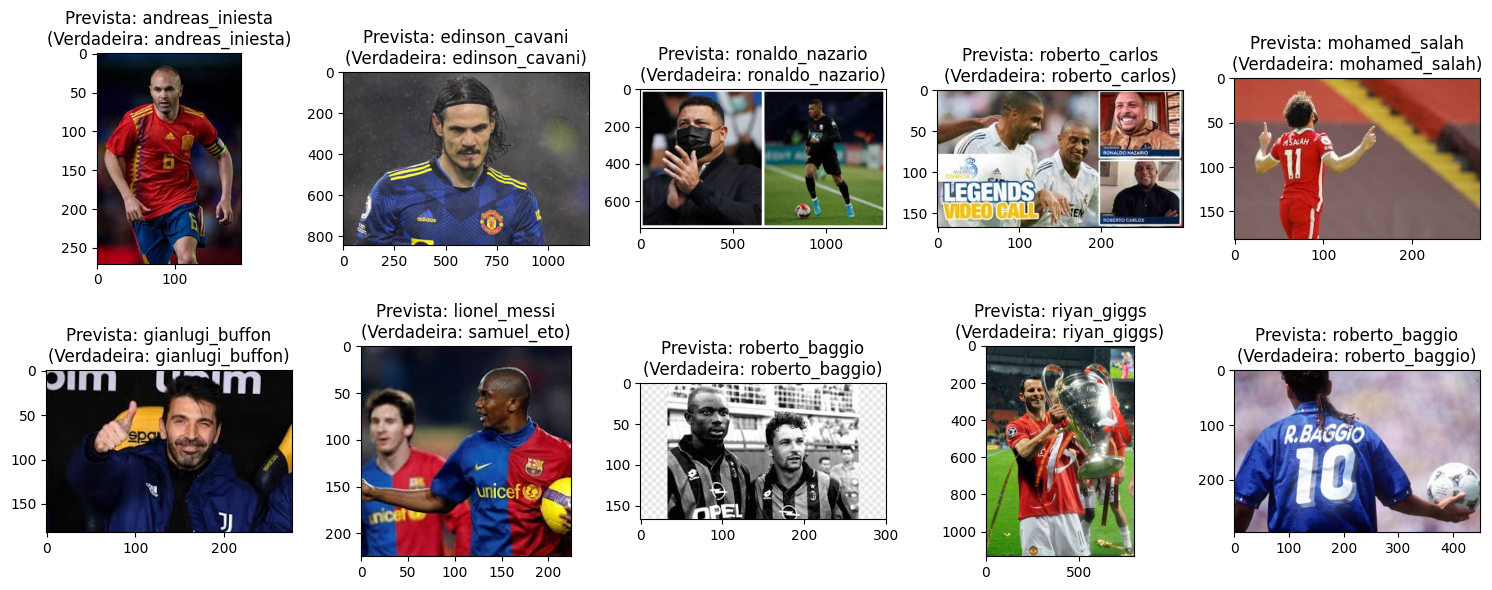

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import re

# Função para exibir as imagens com as classes previstas e verdadeiras
def plot_images_with_predictions(image_paths, predicted_classes, true_classes):
    num_images = len(image_paths)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols  # Arredonda para cima

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))
    fig.subplots_adjust(hspace=2, wspace=0.5)  # Ajuste de espaçamento

    for i, ax in enumerate(axs.flat):
        if i < num_images:
            # Verificar se o índice é válido
            if i < len(image_paths):
                # Verificar se o caminho da imagem é válido
                if os.path.exists(image_paths[i][0]):
                    # Carregar a imagem
                    img = mpimg.imread(image_paths[i][0])
                    # Exibir a imagem
                    ax.imshow(img)
                    ax.set_title(f"Prevista: {predicted_classes[i]}\n(Verdadeira: {true_classes[i]})", fontsize=12)
                else:
                    # Caminho da imagem inválido, ocultar eixo
                    ax.axis('off')
            else:
                # Índice inválido, ocultar eixo
                ax.axis('off')
        else:
            # Não há mais imagens, ocultar eixo
            ax.axis('off')

    plt.tight_layout()
    plt.show()


image_paths = caminhos

try:
# Extrair a classe verdadeira do caminho da imagem
  true_classes = [re.search(r'test/(.*?)/', path[0]).group(1) for path in image_paths]
except Exception as e:
  pass


predicted_classes = predicted_classes
# Exibir as imagens com as classes previstas e verdadeiras
plot_images_with_predictions(caminhos, predicted_classes, true_classes)


##**Previsão para uma Única Imagem**

- Carregamos uma imagem específica (neste caso utilizamos uma imagem do Ronaldinho) e realizamos a pré-processamento (redimensionamento e normalização).
- Fazemos a previsão para a imagem e obtemos as classes previstas e suas probabilidades.
- Exibimos as classes com as maiores probabilidades junto com a imagem

1/1 [==============================] - 0s 24ms/step
Classe prevista: ronaldo_nazario (probabilidade: 0.9971)

Outras classes com altas probabilidades:
ronaldo_nazario: 0.9971
iker_casillas: 0.0024
roberto_carlos: 0.0003
riyan_giggs: 0.0000
francesco_totti: 0.0000


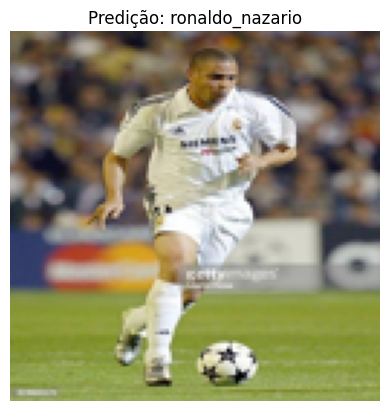

In [ ]:
# Carregar a imagem de entrada
image_path = '/content/data/test/ronaldo_nazario/cd28bd90dc.jpg'
img = Image.open(image_path).convert('RGB')

# Pré-processar a imagem (redimensionar e normalizar)
img = img.resize((img_size, img_size))
input_image = np.array(img) / 255.0  # Normalizar os valores dos pixels


input_image = input_image.reshape(1, img_size, img_size, 3)

# Fazer a previsão
predictions = model_one.predict(input_image)

# Obter os índices das classes previstas e suas respectivas probabilidades
predicted_class_indices = np.argmax(predictions, axis=1)
predicted_class_probabilities = predictions[0]

# Mapear os índices previstos para os nomes das classes
predicted_classes = [jogadores[i] for i in predicted_class_indices]

# Exibir as classes com maior probabilidade
top_n = 5  # Quantidade de classes com maior probabilidade a serem exibidas
top_indices = np.argsort(predicted_class_probabilities)[::-1][:top_n]

print(f"Classe prevista: {jogadores[predicted_class_indices[0]]} (probabilidade: {predicted_class_probabilities[predicted_class_indices[0]]:.4f})")
print("\nOutras classes com altas probabilidades:")
for i in top_indices:
    print(f"{jogadores[i]}: {predicted_class_probabilities[i]:.4f}")

# Visualizar a imagem e as previsões
import matplotlib.pyplot as plt

plt.imshow(input_image[0])
plt.title(f"Predição: {jogadores[predicted_class_indices[0]]}")
plt.axis('off')
plt.show()


#Testes Modelo Treinado do Zero

##**Seleção de Imagens Aleatórias e Previsões**

- Importamos as bibliotecas os e random para manipulação de arquivos e seleção aleatória, respectivamente.
- Definimos o caminho para a pasta que contém as imagens de teste
- Especificamos a quantidade de imagens que queremos selecionar aleatoriamente (10).
- Listamos todas as pastas dentro da pasta principal e selecionamos aleatoriamente uma delas
- Dentro da pasta selecionada, listamos todos os arquivos de imagem e escolhemos aleatoriamente uma imagem.
- Repetimos o processo até termos 10 caminhos de imagens aleatórias.

In [ ]:
import os
import random
caminhos  = []
# Pasta onde estão localizadas as pastas de imagens de teste
pasta_principal = '/content/data/test'

quant_imagens = 10

for _ in range(quant_imagens):
  # Listar todas as pastas dentro da pasta principal
  pastas = [pasta for pasta in os.listdir(pasta_principal) if os.path.isdir(os.path.join(pasta_principal, pasta))]

  # Selecionar aleatoriamente uma das pastas
  pasta_selecionada = random.choice(pastas)

  # Caminho completo para a pasta selecionada
  caminho_pasta_selecionada = os.path.join(pasta_principal, pasta_selecionada)

  # Listar todos os arquivos de imagem dentro da pasta selecionada
  arquivos_imagens = [os.path.join(caminho_pasta_selecionada, arquivo) for arquivo in os.listdir(caminho_pasta_selecionada) if arquivo.endswith('.png') or arquivo.endswith('.jpg')]

  # Selecionar aleatoriamente 1 caminhos no arquivo de imagens
  caminho_aleatorio = random.sample(arquivos_imagens, 1)
  caminhos.append(caminho_aleatorio)

# Agora, caminhos contém os caminhos completos de 10 imagens aleatórias da pasta selecionada
print(caminhos)


[['/content/data/test/samuel_eto/d01e4f77ef.jpg'], ['/content/data/test/francesco_totti/e63a3d391d.jpg'], ['/content/data/test/cristiano_ronaldo/ae440e252b.jpg'], ['/content/data/test/pele/68e244370d.jpg'], ['/content/data/test/mohamed_salah/1c863e47a6.jpg'], ['/content/data/test/ronaldinho/c1731a8419.jpg'], ['/content/data/test/alessandro_del_piero/a903aab90d.jpg'], ['/content/data/test/andriy_shevchenko/7a40bc6b04.jpg'], ['/content/data/test/riyan_giggs/84cbd2cc20.jpg'], ['/content/data/test/diego_maradona/e0f44ef2e0.jpg']]


**Carregamento e Pré-processamento das Imagens**
- Usamos a biblioteca PIL para carregar e redimensionar as imagens.
- Convertemos as imagens para um formato adequado para a entrada do modelo de rede neural convolucional.
- Normalizamos os valores dos pixels das imagens para o intervalo [0, 1].


In [ ]:
from PIL import Image
import numpy as np

# Converter a lista de listas em uma lista simples
image_paths = [path[0] for path in caminhos]

# Carregar todas as imagens e redimensioná-las
images = []
for image_path in image_paths:
    img = Image.open(image_path).convert('RGB')
    resized_img = img.resize((img_size, img_size))
    images.append(resized_img)

# Converter a lista de imagens em uma matriz numpy
images_array = np.array([np.array(img) for img in images])

# Adicionar dimensões extras para corresponder à entrada da CNN
input_images = np.expand_dims(images_array, axis=-1)
input_images = np.expand_dims(input_images, axis=0)  # Adicionando uma dimensão para corresponder ao tamanho do lote

# Normalização
input_images = input_images.reshape(len(image_paths), img_size, img_size, 3)

input_images = input_images / 255.0

##**Previsões do Modelo**
- Fazemos previsões usando o modelo treinado.
- Obtemos os índices das classes com maior probabilidade para cada imagem.
- Mapeamos esses índices para os nomes das classes de jogadores.

In [ ]:
# Fazer previsões
predictions = model.predict(input_images)

# Obter os índices das classes previstas para todas as imagens
predicted_class_indices = np.argmax(predictions, axis=1)

# Mapear os índices previstos para os nomes das classes
predicted_classes = [jogadores[i] for i in predicted_class_indices]

1/1 [==============================] - 0s 112ms/step


**Verificação das Previsões**

- Extraímos as classes verdadeiras dos caminhos das imagens.
- Comparamos as classes verdadeiras com as classes previstas e contamos o número de acertos e erros.

In [ ]:
import re

# Lista de caminhos das imagens
image_paths = caminhos

cont_erro = 0
cont_acerto = 0

# Classes previstas
predicted_classes = predicted_classes

try:
# Extrair a classe verdadeira do caminho da imagem
  true_classes = [re.search(r'test/(.*?)/', path[0]).group(1) for path in image_paths]
except Exception as e:
  pass

# Mostrar as classes verdadeiras e as classes previstas lado a lado
print("Classe Verdadeira\tClasse prevista")
for true_class, predicted_class in zip(true_classes, predicted_classes):
    if true_class != predicted_class:
        print(f"{true_class:<20}\t{predicted_class} ERRO!!")
        cont_erro+=1
    else:
        print(f"{true_class:<20}\t{predicted_class}")
        cont_acerto += 1
print()
print()
print(f"Em {len(image_paths)} predições, o modelo obteve {cont_acerto} previsões corretas")

Classe Verdadeira	Classe prevista
samuel_eto          	samuel_eto
francesco_totti     	francesco_totti
cristiano_ronaldo   	cristiano_ronaldo
pele                	pele
mohamed_salah       	riyan_giggs ERRO!!
ronaldinho          	ronaldinho
alessandro_del_piero	alessandro_del_piero
andriy_shevchenko   	andriy_shevchenko
riyan_giggs         	riyan_giggs
diego_maradona      	diego_maradona


Em 10 predições, o modelo obteve 9 previsões corretas


**Visualização das Imagens com Previsões**

Extraímos as classes verdadeiras dos caminhos das imagens e exibimos as imagens com as classes previstas e verdadeiras

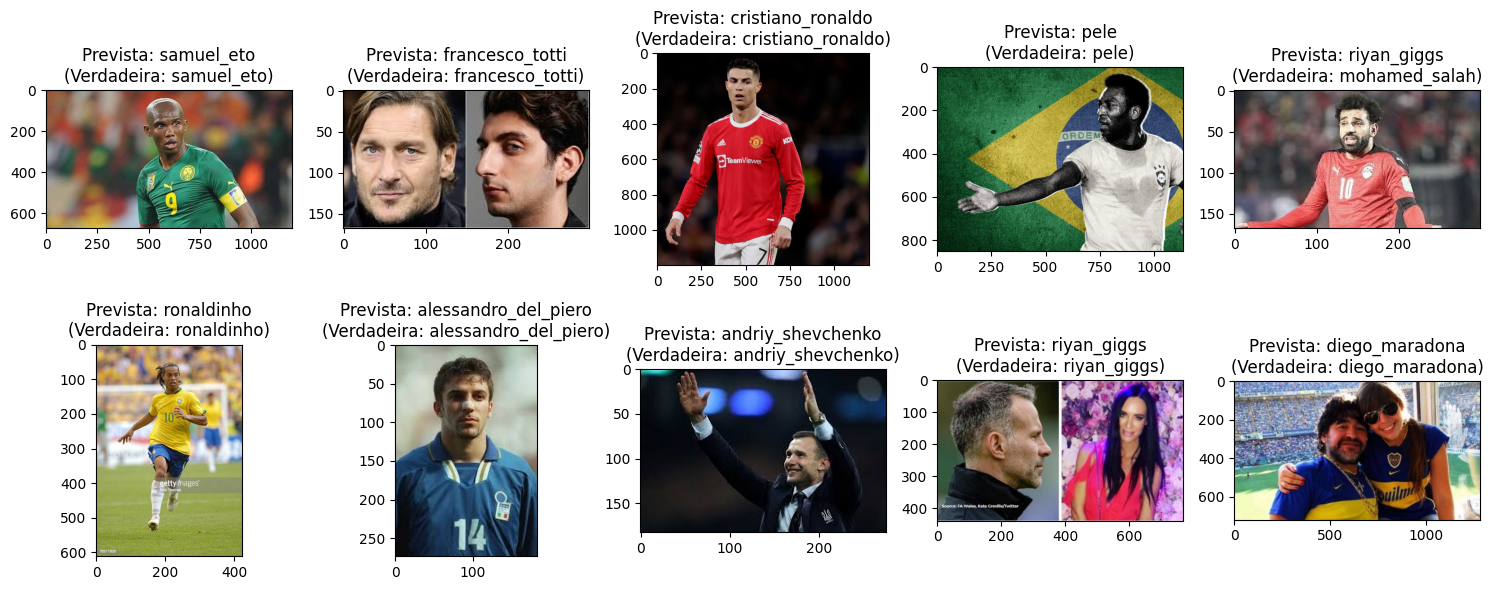

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import re

# Função para exibir as imagens com as classes previstas e verdadeiras
def plot_images_with_predictions(image_paths, predicted_classes, true_classes):
    num_images = len(image_paths)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols  # Arredonda para cima

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))
    fig.subplots_adjust(hspace=2, wspace=0.5)  # Ajuste de espaçamento

    for i, ax in enumerate(axs.flat):
        if i < num_images:
            # Verificar se o índice é válido
            if i < len(image_paths):
                # Verificar se o caminho da imagem é válido
                if os.path.exists(image_paths[i][0]):
                    # Carregar a imagem
                    img = mpimg.imread(image_paths[i][0])
                    # Exibir a imagem
                    ax.imshow(img)
                    ax.set_title(f"Prevista: {predicted_classes[i]}\n(Verdadeira: {true_classes[i]})", fontsize=12)
                else:
                    # Caminho da imagem inválido, ocultar eixo
                    ax.axis('off')
            else:
                # Índice inválido, ocultar eixo
                ax.axis('off')
        else:
            # Não há mais imagens, ocultar eixo
            ax.axis('off')

    plt.tight_layout()
    plt.show()


image_paths = caminhos

try:
# Extrair a classe verdadeira do caminho da imagem
  true_classes = [re.search(r'test/(.*?)/', path[0]).group(1) for path in image_paths]
except Exception as e:
  pass


predicted_classes = predicted_classes
# Exibir as imagens com as classes previstas e verdadeiras
plot_images_with_predictions(caminhos, predicted_classes, true_classes)


##**Previsão para uma Única Imagem**

- Carregamos uma imagem específica (neste caso utilizamos uma imagem do Ronaldinho) e realizamos a pré-processamento (redimensionamento e normalização).
- Fazemos a previsão para a imagem e obtemos as classes previstas e suas probabilidades.
- Exibimos as classes com as maiores probabilidades junto com a imagem

1/1 [==============================] - 0s 105ms/step
Classe prevista: cristiano_ronaldo (probabilidade: 0.9999)

Outras classes com altas probabilidades:
cristiano_ronaldo: 0.9999
edinson_cavani: 0.0001
luka_modric: 0.0000
iker_casillas: 0.0000
ronaldo_nazario: 0.0000


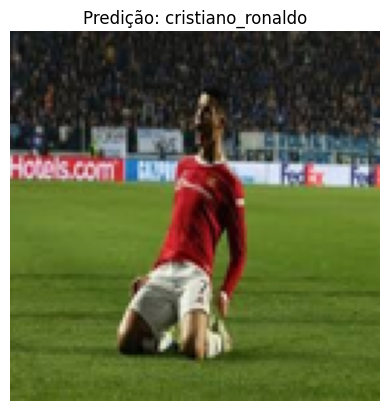

In [ ]:
# Carregar a imagem de entrada
image_path = '/content/data/test/cristiano_ronaldo/3cebda7e0c.jpg'
img = Image.open(image_path).convert('RGB')

# Pré-processar a imagem (redimensionar e normalizar)
img = img.resize((img_size, img_size))
input_image = np.array(img) / 255.0  # Normalizar os valores dos pixels


input_image = input_image.reshape(1, img_size, img_size, 3)

# Fazer a previsão
predictions = model.predict(input_image)

# Obter os índices das classes previstas e suas respectivas probabilidades
predicted_class_indices = np.argmax(predictions, axis=1)
predicted_class_probabilities = predictions[0]

# Mapear os índices previstos para os nomes das classes
predicted_classes = [jogadores[i] for i in predicted_class_indices]

# Exibir as classes com maior probabilidade
top_n = 5  # Quantidade de classes com maior probabilidade a serem exibidas
top_indices = np.argsort(predicted_class_probabilities)[::-1][:top_n]

print(f"Classe prevista: {jogadores[predicted_class_indices[0]]} (probabilidade: {predicted_class_probabilities[predicted_class_indices[0]]:.4f})")
print("\nOutras classes com altas probabilidades:")
for i in top_indices:
    print(f"{jogadores[i]}: {predicted_class_probabilities[i]:.4f}")

# Visualizar a imagem e as previsões
import matplotlib.pyplot as plt

plt.imshow(input_image[0])
plt.title(f"Predição: {jogadores[predicted_class_indices[0]]}")
plt.axis('off')
plt.show()


#**Conclusões**

Neste projeto, investigamos o uso de redes neurais convolucionais (CNNs) para a classificação de imagens de jogadores de futebol, utilizando o dataset "Golden Foot Football Players Image Dataset" do Kaggle. O dataset foi estruturado em várias classes, cada uma representando um jogador de futebol, e as imagens foram redimensionadas para uma resolução padrão de 128x128 pixels. Nossa abordagem incluiu tanto o uso de modelos pré-treinados quanto modelos treinados do zero, explorando diversas combinações de hiperparâmetros para otimizar o desempenho do modelo.

Os experimentos com modelos pré-treinados, especificamente utilizando a arquitetura ResNet50, mostraram que a inclusão de camadas densas adicionais com diferentes números de neurônios e funções de ativação impacta significativamente a precisão do modelo. Por exemplo, a variação com 2048 neurônios e ativação ReLU nas camadas densas resultou em uma precisão de teste de 83,19%, enquanto a utilização de ativação Tanh em uma configuração similar alcançou uma precisão de 84,32%. Esses resultados destacam a importância da seleção adequada de funções de ativação e do número de neurônios para melhorar a capacidade do modelo de generalizar em novos dados.

Nos testes realizados com modelos treinados do zero, foi observado que a combinação de várias camadas convolucionais e densas, juntamente com técnicas de regularização como batch normalization e dropout, ajudou a reduzir o overfitting e a melhorar a performance do modelo. A variação de maior acurácia atingiu 78,77%, utilizando 26 camadas com neurônios nas camadas convolucionais e densas, e empregando a função de ativação ReLU e o otimizador Adam. Em resumo, os experimentos confirmam que a construção cuidadosa de arquiteturas de CNN, combinada com a experimentação sistemática de diferentes hiperparâmetros, é crucial para alcançar resultados robustos em tarefas de classificação de imagens.
